# Introduction
This is an example of a Python notebook used to train a model (decision tree) and then export it as PMML so that it can be easily integrated with additional decision logic (DMN https://drools.org/learn/dmn.html)

### Prerequisite
To run this notebook you need to have:
- Python 3 https://www.python.org/downloads/
- Pip https://pypi.org/project/pip/

Install dependencies:
- jupyterlab
- pandas
- sklearn
- numpy
- nyoka
- matplotlib

All of them can be installed cloning this repo and using command `pip install -r requirements.txt`

Finally start the environment using the command `jupyter notebook`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

# Step 1 - Load and prepare data
Data are usually available as unstructure files with text (csv) or binary (parquet, avro) format and there are many libraries to load them from a local or remote storage.

After the loading step it is quite common to perform some preparation/cleanup actions: check domain boundaries, handle missing values, normalize strings, convert enumaration to number, etc.

In [2]:
df = pd.read_csv('input_data.csv')
df.head()

,holder_index,amount,dispute_risk
0,0,246.35,5
1,0,10.00,2
2,1,113.05,2
3,2,159.58,3
4,0,197.64,4


# Step 2 - Prepare training set and test set
When a model is trained, it is important to use different set of data to train and test it

In [3]:
test_size = 0.4             # percentage of data used to create test set
random_state = 23           # fixed seed to make randomization reproducible
inputs = df[['amount', 'holder_index']]
outputs = df['dispute_risk']

input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, test_size=test_size, random_state=random_state)


# Step 3 - Train the model
There are many different models that can be used. In this example we will use a decision tree classifier

In [4]:
pipeline = Pipeline([
    ("classifier", DecisionTreeClassifier())
])
trained_model = pipeline.fit(input_train, output_train)

# Step 4 - Test the mode

There are multiple way to test the model, first of all you should test it using test data

In [5]:
model_score = trained_model.score(input_test, output_test)
print("model_score: " + str(model_score))

model_score: 0.975


Note: Pay attention to overfitting problem ( https://en.wikipedia.org/wiki/Overfitting )  while you train and test your model. For example a score of 0.99 or similar is an important sign of a probable overfit.

Additionally you can print to visually compare predicted data with real data

In [6]:
predictions = trained_model.predict(input_test)
results = pd.DataFrame({'dtree prediction': predictions.astype(int),
                        'truth': output_test})
results.head(20)

,dtree prediction,truth
519,2,2
837,2,2
208,2,2
525,2,2
978,2,2
583,2,2
508,3,3
158,3,3
589,3,3
201,2,2


Another approach is to plot predicted data and real data on the same chart

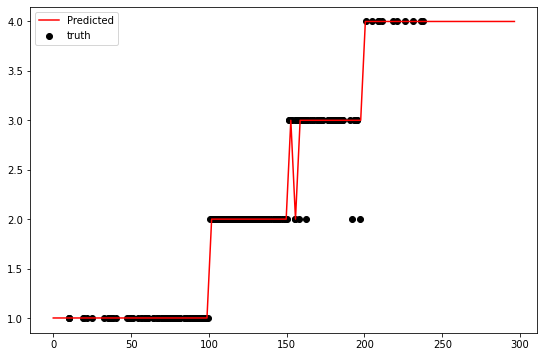

In [7]:
predictions = trained_model.predict(input_test)
plt.rcParams["figure.figsize"] = (20,6)

holder_index = 2
testing = pd.DataFrame({'amount': np.linspace(0, input_test['amount'].max(), 100), 'holder_index': holder_index})
sub_test = df[df['holder_index']==holder_index]

DT_predictions = trained_model.predict(testing).astype(int)
plt.subplot(121)
plt.plot(testing['amount'], DT_predictions, color='red', label='Predicted')
plt.scatter(sub_test['amount'], sub_test['dispute_risk'], color='black', label='truth')
plt.legend()
plt.show()

Scoring and visualization are just simple ways to test the trained model. They are usually not enough for real world use cases.

There are advanced way to analyze how the model is performing (i.e. ROC) and there are many other aspects to consider: fairness, explanability, interpretability.

Additional resources:
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- https://christophm.github.io/interpretable-ml-book/

# Step 5 - Save the model as PMML
When your are happy with your model you can export it as PMML.

In [8]:
skl_to_pmml(trained_model, ['amount', 'holder_index'], 'dispute_risk',
                "dtree_risk_predictor.pmml")